Optimized Parameters:
A1: 0.000999041641782571
g1: 1.366018240607317
A2: 0.0009965520161816916
g2: 0.879688299271902
kb: 1.0
b: 0.1225540923652376


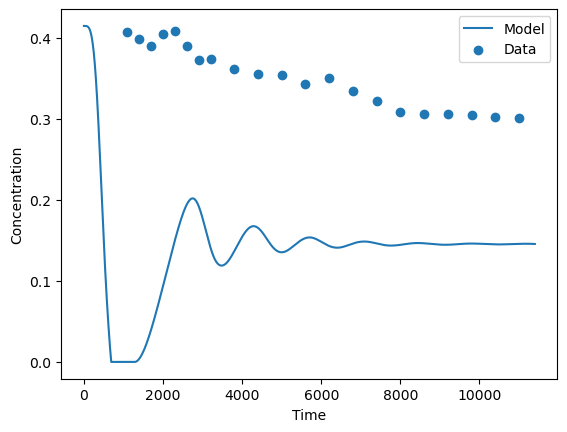

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

Time2 = [1100,1400,1700,2000,2300,2600,2900,3200,3800,4400,5000,5600,6200,6800,7400,8000,8600,9200,9800,10400,11000]
Concentration2 = [0.4065976517, 0.398277282,0.3890997554,0.4042709267,0.4085997167,0.3893013659,0.3723033081,0.3730377399,0.361164624,0.3552221335,0.354109998,0.3422237102,0.3497295156,0.3346530385,0.3212697806,0.3079156156,0.3056669584,0.3060808548,0.3039224302,0.3023205142,0.3010328339]

def generateODE2(t, m, A1, g1, A2, g2, kb, b, V):
    # Unpack the variables from the y vector
    m00, m10, m01, m11, c = m

    Ci = 0.4143                     # gm/(100 gm of mixed solvent)
    Ce = 0.1253                     # gm/(100 gm of mixed solvent)
    
    #calulate neccessary quantity
    
    f = 2.5 * 10**-7                     # m3/sec 
    ρc = 1400 * 10**3                    # gm/m3
    h = 1 * 10**(-5)                     # m
    Vc = h * m11
    ρl = 785 * 10**3                     # gm/m3
    V = 0.0002
    tau = V / f
    
    delta_c = max(c - Ce, 0)
    s = delta_c / Ce
    
    Gl = A1 * (s)**g1
    Gw = A2 * (s)**g2
    B = kb * (s)**b

    dm00 = B - (m00 / tau)
    dm10 = (Gl * m00) - (m10 / tau)
    dm01 = (Gw * m00) - (m01 / tau)
    dm11 = (Gl * m10) + (Gw * m01) - (m11 / tau)
    dc = (Ci / tau) - (c / tau) - (ρc / ρl) * Vc
    if c + dc < 0:
        dc = -c

    return [dm00, dm10, dm01, dm11, dc]
def objective(params):
    A1, g1, A2, g2, kb, b = params
    V = 0.0002  # Volume, adjust as needed
    t_span = (0, 11400)  # Adjust this to match the maximum time in your data
    num_points = 11400
    initialConditions = [0, 0, 0, 0, 0.6213]
    sol = solve_ivp(
        lambda t, m: generateODE2(t, m, A1, g1, A2, g2, kb, b, V),
        t_span,
        initialConditions,
        t_eval=np.linspace(t_span[0], t_span[1], num_points)
    )
    
    # Ensure that the interpolation is within the range of the solution
    interp_t = np.clip(Time2, sol.t[0], sol.t[-1])
    
    # Interpolate the solution at the time points specified in Time
    interp_solution = interp1d(sol.t, sol.y[4])
    model_predictions = interp_solution(Time2)
    error = np.sum((model_predictions - Concentration2)**2)  # Sum of squared differences
    return error

# Initial guess for parameters
initial_guess = [0.001, 1.3674422124010206, 0.001, 0.8806401378356327, 0.009159735378591962, 0.11727791169769848]

# Bounds for the parameters
bounds = [(0.0001, 0.1),   # A1
          (0.05, 2),      # g1
          (0.0001, 0.01),     # A2
          (0.00001, 1),        # g2
          (1, 3),        # kb
          (0.1, 5)]        # b

# Minimize the objective function with bounds
result = minimize(objective, initial_guess, method='L-BFGS-B', bounds=bounds)

# Extract the optimized parameters
A1_opt, g1_opt, A2_opt, g2_opt, kb_opt, b_opt = result.x

print("Optimized Parameters:")
print("A1:", A1_opt)
print("g1:", g1_opt)
print("A2:", A2_opt)
print("g2:", g2_opt)
print("kb:", kb_opt)
print("b:", b_opt)

# Plot the optimized model against the data
t_span = (0, 11400)
num_points = 11400
initialConditions = [0, 0, 0, 0, 0.4143]
sol = solve_ivp(
    lambda t, m: generateODE2(t, m, A1_opt, g1_opt, A2_opt, g2_opt, kb_opt, b_opt, 0.0002),
    t_span,
    initialConditions,
    t_eval=np.linspace(t_span[0], t_span[1], num_points)
)
plt.plot(sol.t, sol.y[4], label='Model')
plt.scatter(Time2, Concentration2, label='Data')
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.legend()
plt.show()

In [ ]:
0.001, 1.3674422124010206, 0.001, 0.8806401378356327, 0.009159735378591962, 0.11727791169769848